<a href="https://colab.research.google.com/github/zwimpee/cursivetransformer/blob/main/HookedCursiveTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HookedCursiveTransformer

# Setup

In [24]:
import os
DEVELOPMENT_MODE = False
# Detect if we're running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

# Install if in Colab
if IN_COLAB:
    %pip install transformer_lens
    %pip install circuitsvis
    # Install a faster Node version
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs  # noqa

# Hot reload in development mode & not running on the CD
if not IN_COLAB:
    from IPython import get_ipython
    ip = get_ipython()
    if not ip.extension_manager.loaded:
        ip.extension_manager.load('autoreload')
        %autoreload 2

IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"

Running as a Colab notebook
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [25]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [62]:
!pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
!pip install transformer_lens
!pip install gradio
!pip install wandb
!pip install einops
!pip install matplotlib
!pip install datasets

# Clone the cursivetransformer repository and install its requirements
!rm -rf cursivetransformer && git clone https://github.com/zwimpee/cursivetransformer.git
!pip install -r cursivetransformer/requirements.txt

# Login to Weights & Biases (replace 'your_api_key' with your actual API key)
import wandb
wandb.login()

  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-vj6g8zo6
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-vj6g8zo6
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for circuitsvis: filename=circuitsvis-0.0.0-py3-none-any.whl size=6172334 sha256=59415c32edc93016c6c42f3b4833706a3be43b700e7573be5495cc7c0ec5f306
  Stored in directory: /tmp/pip-ephem-wheel-cache-25r2djpj/wheels/86/be/ad/78078aba9344d200aad61b63d35cdaecdec160212f039eed74
Successfully built circuitsvis
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 8.4.0
    Uninstalling importlib_metadata-8.4.0:
      Successfully uninstalled importlib_metadata-8.4.0
  Attem

True

In [63]:
import circuitsvis as cv
# Testing that the library works
cv.examples.hello("Neel")

In [27]:
import sys
sys.path.append('/content/cursivetransformer')  # Adjust the path if necessary

import sys
import os
import copy
import types

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from jaxtyping import Float, Int

import einops
import matplotlib.pyplot as plt
import seaborn as sns
# import circuitsvis as cv
from IPython.display import display

from typing import Callable, Dict, Optional, Union

from cursivetransformer.model import (
    get_all_args,
    get_checkpoint,
    get_latest_checkpoint_artifact
)
from cursivetransformer.data import (
    create_datasets,
    offsets_to_strokes
)
from cursivetransformer.sample import (
    generate,
    generate_n_words,
    plot_strokes
)
from transformer_lens import (
    HookedTransformer,
    HookedTransformerConfig
)
from transformer_lens.hook_points import HookPoint
from transformer_lens.utils import (
    get_act_name,
    repeat_along_head_dimension
)
from transformer_lens.utilities.attention import simple_attn_linear
from transformer_lens.components import (
    Attention,
    GroupedQueryAttention,
    LayerNorm,
    LayerNormPre,
    RMSNorm,
    RMSNormPre,
    Embed,
    Unembed
)
from transformer_lens.components.mlps.can_be_used_as_mlp import CanBeUsedAsMLP
from transformer_lens.past_key_value_caching import HookedTransformerKeyValueCacheEntry

import logging
from collections import defaultdict
from typing import Dict, List, Optional, Tuple, Union, cast

import numpy as np
import torch
from typing_extensions import Literal, get_args

from transformer_lens.ActivationCache import ActivationCache
from transformer_lens.HookedTransformer import HookedTransformer
from transformer_lens.utils import is_lower_triangular, is_square
from transformer_lens.utilities.addmm import batch_addmm

In [28]:
torch.set_grad_enabled(False)

In [29]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [3]:
# Usage example:
args = get_all_args(False)
args.sample_only = True
args.load_from_run_id = '6le6tujz'  # Replace with your actual run ID
args.wandb_entity = 'sam-greydanus'
args.dataset_name = 'bigbank'  # Replace with your dataset name
args.wandb_run_name = 'cursivetransformer_dictionary_learning'

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)

args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()

Trying to load dataset file from /content/cursivetransformer/data/bigbank.json.zip
Succeeded in loading the bigbank dataset; contains 1900 items.
For a dataset of 1805 examples we can generate 440811596555 combinations of 4 examples.
Generating 497000 4-word examples.
For a dataset of 95 examples we can generate 3183545 combinations of 4 examples.
Generating 3000 4-word examples.
Number of examples in the train dataset: 497000
Number of examples in the test dataset: 3000
Max token sequence length: 1000
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 497000 training examples and 3000 test examples


In [37]:
class HookedCursiveTransformerConfig(HookedTransformerConfig):
    def __init__(self, **kwargs):
        # Extract custom arguments
        self.d_model_c = kwargs.pop('d_model_c', None)
        self.context_block_size = kwargs.pop('context_block_size', None)
        self.context_vocab_size = kwargs.pop('context_vocab_size', None)
        # self.use_cross_attention = kwargs.pop('use_cross_attention', True)

        # W&B specific parameters
        self.wandb_entity = kwargs.pop('wandb_entity', None)
        self.wandb_project = kwargs.pop('wandb_project', None)
        self.load_from_run_id = kwargs.pop('load_from_run_id', None)

        # Now, call the superclass constructor with the remaining kwargs
        super().__init__(**kwargs)

    @classmethod
    def from_dict(cls, config_dict):
        return cls(**config_dict)

class HookedCursiveTransformer(HookedTransformer):
    def __init__(self, cfg):
        super().__init__(cfg)
        self.cfg = cfg

        # Embedding layers
        self.embed = nn.Embedding(cfg.d_vocab, cfg.d_model)
        self.pos_embed = nn.Embedding(cfg.n_ctx, cfg.d_model)
        self.embed_c = nn.Embedding(cfg.context_vocab_size, cfg.d_model_c)
        self.pos_embed_c = nn.Embedding(cfg.context_block_size, cfg.d_model_c)

        # Projection layer if d_model_c != d_model
        if cfg.d_model_c != cfg.d_model:
            self.context_proj = nn.Linear(cfg.d_model_c, cfg.d_model)
        else:
            self.context_proj = nn.Identity()

        # Blocks
        self.blocks = nn.ModuleList([TransformerBlock(cfg, block_index=_) for _ in range(cfg.n_layers)])

        # Final layers
        self.ln_final = nn.LayerNorm(cfg.d_model)
        self.unembed = nn.Linear(cfg.d_model, cfg.d_vocab, bias=True)

        # Hook points
        self.hook_embed = HookPoint()
        self.hook_pos_embed = HookPoint()
        self.hook_embed_c = HookPoint()
        self.hook_pos_embed_c = HookPoint()

        self.setup()

    def forward(self, tokens, context, return_type="logits"):
        B, T = tokens.shape
        B_c, T_c = context.shape

        token_embed = self.hook_embed(self.embed(tokens))
        pos_embed = self.hook_pos_embed(self.pos_embed(torch.arange(T, device=tokens.device)))
        x = token_embed + pos_embed

        context_embed = self.hook_embed_c(self.embed_c(context))
        context_pos_embed = self.hook_pos_embed_c(self.pos_embed_c(torch.arange(T_c, device=context.device)))
        c = context_embed + context_pos_embed
        c = self.context_proj(c)
        for block in self.blocks:
            x = block(x, c)

        x = self.ln_final(x)
        logits = self.unembed(x)

        if return_type == "logits":
            return logits
        elif return_type == "loss":
            return self.loss_fn(logits, tokens[:, 1:])
        elif return_type == "both":
            return logits, self.loss_fn(logits, tokens[:, 1:])
        else:
            raise ValueError(f"Invalid return_type {return_type}")

    @classmethod
    def from_pretrained(
        cls,
        model_name: str,
        cfg,
        tokenizer=None,
        **from_pretrained_kwargs
    ):
        """
        Load a pretrained CursiveTransformer model into the HookedCursiveTransformer format.

        Args:
            model_name (str): The name or path of the pretrained model.
            cfg: The configuration object for the model.
            tokenizer: The tokenizer to use (optional).
            **from_pretrained_kwargs: Additional keyword arguments.

        Returns:
            HookedCursiveTransformer: The loaded model.
        """
        print(f"Loading pretrained model {model_name}")

        # Initialize the HookedCursiveTransformer with the given config
        model = cls(cfg)

        # Load the state dict from the wandb artifact
        state_dict = cls.load_state_dict_from_wandb(cfg)

        # Convert the state dict to match HookedCursiveTransformer format
        converted_state_dict = cls.convert_cursivetransformer_weights(state_dict, cfg)

        # Load the converted state dict into the model
        model.load_state_dict(converted_state_dict, strict=False)

        if tokenizer is not None:
            model.tokenizer = tokenizer

        print(f"Successfully loaded pretrained model {model_name}")
        return model

    @staticmethod
    def load_state_dict_from_wandb(args):
        artifact = get_latest_checkpoint_artifact(args)
        artifact_dir = artifact.download()
        checkpoint = torch.load(os.path.join(artifact_dir, "best_checkpoint.pt"), weights_only=True)
        return checkpoint['model_state_dict']

    @staticmethod
    def convert_cursivetransformer_weights(state_dict, cfg):
        """Convert CursiveTransformer weights to HookedCursiveTransformer format."""
        new_state_dict = {}

        # Embeddings
        new_state_dict["embed.W_E"] = state_dict["transformer.wte.weight"]
        new_state_dict["pos_embed.W_pos"] = state_dict["transformer.wpe.weight"]
        new_state_dict["embed_c.W_E"] = state_dict["transformer.wce.weight"]
        new_state_dict["pos_embed_c.W_pos"] = state_dict["transformer.wcpe.weight"]

        for l in range(cfg.n_layers):
            # Layer Norms
            new_state_dict[f'blocks.{l}.ln1.w'] = state_dict[f'transformer.h.{l}.ln_1.weight']
            new_state_dict[f'blocks.{l}.ln1.b'] = state_dict[f'transformer.h.{l}.ln_1.bias']
            new_state_dict[f'blocks.{l}.ln2.w'] = state_dict[f'transformer.h.{l}.ln_2.weight']
            new_state_dict[f'blocks.{l}.ln2.b'] = state_dict[f'transformer.h.{l}.ln_2.bias']
            new_state_dict[f'blocks.{l}.ln3.w'] = state_dict[f'transformer.h.{l}.ln_3.weight']
            new_state_dict[f'blocks.{l}.ln3.b'] = state_dict[f'transformer.h.{l}.ln_3.bias']

            # Self-Attention
            W_qkv = state_dict[f'transformer.h.{l}.attn.c_attn.weight']
            b_qkv = state_dict[f'transformer.h.{l}.attn.c_attn.bias']
            W_q, W_k, W_v = W_qkv.t().chunk(3, dim=1)
            b_q, b_k, b_v = b_qkv.chunk(3, dim=0)

            new_state_dict[f'blocks.{l}.attn.W_Q'] = W_q.t().reshape(cfg.n_heads, cfg.d_model, cfg.d_head)
            new_state_dict[f'blocks.{l}.attn.W_K'] = W_k.t().reshape(cfg.n_heads, cfg.d_model, cfg.d_head)
            new_state_dict[f'blocks.{l}.attn.W_V'] = W_v.t().reshape(cfg.n_heads, cfg.d_model, cfg.d_head)
            new_state_dict[f'blocks.{l}.attn.b_Q'] = b_q.reshape(cfg.n_heads, cfg.d_head)
            new_state_dict[f'blocks.{l}.attn.b_K'] = b_k.reshape(cfg.n_heads, cfg.d_head)
            new_state_dict[f'blocks.{l}.attn.b_V'] = b_v.reshape(cfg.n_heads, cfg.d_head)

            W_o = state_dict[f'transformer.h.{l}.attn.c_proj.weight']
            new_state_dict[f'blocks.{l}.attn.W_O'] = W_o.t().reshape(cfg.n_heads, cfg.d_head, cfg.d_model)
            new_state_dict[f'blocks.{l}.attn.b_O'] = state_dict[f'transformer.h.{l}.attn.c_proj.bias']

            # Cross-Attention
            W_q = state_dict[f'transformer.h.{l}.cross_attn.c_attn_q.weight']
            b_q = state_dict[f'transformer.h.{l}.cross_attn.c_attn_q.bias']
            new_state_dict[f'blocks.{l}.cross_attn.W_Q'] = W_q.t().reshape(cfg.n_heads, cfg.d_model, cfg.d_head)
            new_state_dict[f'blocks.{l}.cross_attn.b_Q'] = b_q.reshape(cfg.n_heads, cfg.d_head)

            W_kv = state_dict[f'transformer.h.{l}.cross_attn.c_attn_kv.weight']
            b_kv = state_dict[f'transformer.h.{l}.cross_attn.c_attn_kv.bias']
            W_k, W_v = W_kv.t().chunk(2, dim=1)
            b_k, b_v = b_kv.chunk(2, dim=0)

            new_state_dict[f'blocks.{l}.cross_attn.W_K'] = W_k.t().reshape(cfg.n_heads, cfg.d_model_c, cfg.d_head)
            new_state_dict[f'blocks.{l}.cross_attn.W_V'] = W_v.t().reshape(cfg.n_heads, cfg.d_model_c, cfg.d_head)
            new_state_dict[f'blocks.{l}.cross_attn.b_K'] = b_k.reshape(cfg.n_heads, cfg.d_head)
            new_state_dict[f'blocks.{l}.cross_attn.b_V'] = b_v.reshape(cfg.n_heads, cfg.d_head)

            W_o = state_dict[f'transformer.h.{l}.cross_attn.c_proj.weight']
            new_state_dict[f'blocks.{l}.cross_attn.W_O'] = W_o.t().reshape(cfg.n_heads, cfg.d_head, cfg.d_model)
            new_state_dict[f'blocks.{l}.cross_attn.b_O'] = state_dict[f'transformer.h.{l}.cross_attn.c_proj.bias']

            # MLP
            new_state_dict[f'blocks.{l}.mlp.W_in'] = state_dict[f'transformer.h.{l}.mlp.c_fc.weight'].t()
            new_state_dict[f'blocks.{l}.mlp.b_in'] = state_dict[f'transformer.h.{l}.mlp.c_fc.bias']
            new_state_dict[f'blocks.{l}.mlp.W_out'] = state_dict[f'transformer.h.{l}.mlp.c_proj.weight'].t()
            new_state_dict[f'blocks.{l}.mlp.b_out'] = state_dict[f'transformer.h.{l}.mlp.c_proj.bias']

        # Final layer norm and unembedding
        new_state_dict["ln_final.w"] = state_dict["transformer.ln_f.weight"]
        new_state_dict["ln_final.b"] = state_dict["transformer.ln_f.bias"]
        new_state_dict["unembed.W_U"] = state_dict["lm_head.weight"].t()
        new_state_dict["unembed.b_U"] = state_dict.get("lm_head.bias", torch.zeros(cfg.d_vocab))

        return new_state_dict

    def loss_fn(self, logits, targets, per_token=False):
        # Shift targets to align with logits for next-token prediction
        targets_shifted = targets[:, 1:]  # Shift targets by one position
        logits = logits[:, :-1, :]        # Exclude the last logit

        # Reshape logits and targets for cross_entropy
        logits_reshaped = logits.reshape(-1, logits.size(-1))            # Shape: [(batch_size * (seq_len - 1)), vocab_size]
        targets_reshaped = targets_shifted.reshape(-1)                   # Shape: [(batch_size * (seq_len - 1))]

        # Calculate the cross-entropy loss without reduction
        loss = F.cross_entropy(logits_reshaped, targets_reshaped, ignore_index=-1, reduction='none')

        if per_token:
            return loss.view(logits.size(0), -1)  # Reshape back to [batch_size, seq_len - 1]
        else:
            return loss.mean()



class TransformerBlock(nn.Module):
    def __init__(self, cfg: Union[Dict, HookedTransformerConfig], block_index):
        super().__init__()
        self.cfg = HookedCursiveTransformerConfig.unwrap(cfg)

        self.cfg_c = copy.deepcopy(cfg)
        self.cfg_c.attention_dir = 'bidirectional'

        # Determine normalization type
        if self.cfg.normalization_type == "LN":
            normalization_layer = LayerNorm
        elif self.cfg.normalization_type == "LNPre":
            normalization_layer = LayerNormPre
        elif self.cfg.normalization_type == "RMS":
            normalization_layer = RMSNorm
        elif self.cfg.normalization_type == "RMSPre":
            normalization_layer = RMSNormPre
        elif self.cfg.normalization_type is None:
            normalization_layer = lambda cfg: nn.Identity()
        else:
            raise ValueError(f"Invalid normalization_type: {self.cfg.normalization_type}")

        # Initialize layers
        self.ln1 = normalization_layer(cfg)
        self.ln2 = normalization_layer(cfg)
        self.ln3 = normalization_layer(cfg)

        attention_class = Attention
        cross_attention_class = CrossAttention
        self.attn = attention_class(self.cfg, "global", block_index)
        self.cross_attn = cross_attention_class(self.cfg_c, "global", block_index)
        self.mlp = MLPFactory.create_mlp(self.cfg)

        # Hook points
        self.hook_attn_in = HookPoint()
        self.hook_cross_attn_in = HookPoint()
        self.hook_mlp_in = HookPoint()
        self.hook_attn_out = HookPoint()
        self.hook_cross_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid1 = HookPoint()
        self.hook_resid_mid2 = HookPoint()
        self.hook_resid_post = HookPoint()

    def forward(
        self,
        resid_pre: Float[torch.Tensor, "batch pos d_model"],
        context: Float[torch.Tensor, "batch context_len d_model_c"],
        attention_mask: Optional[Int[torch.Tensor, "batch 1 seq_len seq_len"]] = None,
    ) -> Float[torch.Tensor, "batch pos d_model"]:
        resid_pre = self.hook_resid_pre(resid_pre)

        # Self-attention
        attn_in = self.hook_attn_in(resid_pre)
        normalized_attn_in = self.ln1(attn_in)
        attn_out = self.attn(
            query_input=normalized_attn_in,
            key_input=normalized_attn_in,
            value_input=normalized_attn_in,
            attention_mask=attention_mask,
        )
        attn_out = self.hook_attn_out(attn_out)
        resid_mid1 = self.hook_resid_mid1(resid_pre + attn_out)

        # Cross-attention
        cross_attn_in = self.hook_cross_attn_in(resid_mid1)
        normalized_cross_attn_in = self.ln2(cross_attn_in)
        cross_attn_out = self.cross_attn(
            query_input=normalized_cross_attn_in,
            key_input=context,
            value_input=context,
            attention_mask=None,  # No mask for cross-attention
        )
        cross_attn_out = self.hook_cross_attn_out(cross_attn_out)
        resid_mid2 = self.hook_resid_mid2(resid_mid1 + cross_attn_out)

        # MLP
        mlp_in = self.hook_mlp_in(resid_mid2)
        normalized_mlp_in = self.ln3(mlp_in)
        mlp_out = self.mlp(normalized_mlp_in)
        mlp_out = self.hook_mlp_out(mlp_out)

        resid_post = self.hook_resid_post(resid_mid2 + mlp_out)
        return resid_post

class CrossAttention(Attention):
    def __init__(self, cfg, attn_type='global', layer_id=None):
        super().__init__(cfg, attn_type, layer_id)
        self.cfg = cfg

        # Initialize W_K and W_V for cross-attention with d_model_c
        self.W_K = nn.Parameter(
            torch.empty(
                self.cfg.n_heads, self.cfg.d_model_c, self.cfg.d_head, dtype=self.cfg.dtype
            )
        )
        self.W_V = nn.Parameter(
            torch.empty(
                self.cfg.n_heads, self.cfg.d_model_c, self.cfg.d_head, dtype=self.cfg.dtype
            )
        )
        self.b_K = nn.Parameter(
            torch.zeros(self.cfg.n_heads, self.cfg.d_head, dtype=self.cfg.dtype)
        )
        self.b_V = nn.Parameter(
            torch.zeros(self.cfg.n_heads, self.cfg.d_head, dtype=self.cfg.dtype)
        )
        # W_Q and W_O are inherited from AbstractAttention

        # Override the attention direction
        # self.cfg.attention_dir = 'bidirectional'

    def calculate_qkv_matrices(self, query_input, key_input, value_input):
        # query_input: [batch, pos, d_model]
        # key_input and value_input: [batch, kv_pos, d_model_c]

        # Use W_Q and b_Q from AbstractAttention for queries
        q = self.hook_q(simple_attn_linear(query_input, self.W_Q, self.b_Q))
        # Use custom W_K and b_K for keys with d_model_c
        k = self.hook_k(simple_attn_linear(key_input, self.W_K, self.b_K))
        v = self.hook_v(simple_attn_linear(value_input, self.W_V, self.b_V))
        return q, k, v


class MLPFactory:
    @staticmethod
    def create_mlp(cfg):
        return MLP(cfg)

class MLP(CanBeUsedAsMLP):
    def __init__(self, cfg: Union[Dict, HookedTransformerConfig]):
        super().__init__(cfg)
        self.select_activation_function()

        self.W_in = nn.Parameter(torch.empty(self.cfg.d_model, self.d_mlp, dtype=self.cfg.dtype))
        self.b_in = nn.Parameter(torch.zeros(self.d_mlp, dtype=self.cfg.dtype))

        self.W_out = nn.Parameter(torch.empty(self.d_mlp, self.cfg.d_model, dtype=self.cfg.dtype))
        self.b_out = nn.Parameter(torch.zeros(self.cfg.d_model, dtype=self.cfg.dtype))

        self.hook_pre = HookPoint()  # [batch, pos, d_mlp]
        self.hook_post = HookPoint()  # [batch, pos, d_mlp]

    def forward(
        self, x: Float[torch.Tensor, "batch pos d_model"]
    ) -> Float[torch.Tensor, "batch pos d_model"]:
        # This is equivalent to (roughly) W_in @ x + b_in. It's important to
        # use a fused addmm to ensure it matches the Huggingface implementation
        # exactly.
        pre_act = self.hook_pre(batch_addmm(self.b_in, self.W_in, x))  # [batch, pos, d_mlp]

        if (
            self.cfg.is_layer_norm_activation()
            and self.hook_mid is not None
            and self.ln is not None
        ):
            mid_act = self.hook_mid(self.act_fn(pre_act))  # [batch, pos, d_mlp]
            post_act = self.hook_post(self.ln(mid_act))
        else:
            post_act = self.hook_post(self.act_fn(pre_act))  # [batch, pos, d_mlp]
        return batch_addmm(self.b_out, self.W_out, post_act)


def convert_cursivetransformer_model_config(args):
    cfg_dict = {
        # Standard parameters
        "d_model": args.n_embd,
        "n_layers": args.n_layer,
        "d_mlp": args.n_embd * 4,
        "d_head": args.n_embd // args.n_ctx_head,
        "n_heads": args.n_ctx_head,
        "n_ctx": args.max_seq_length,
        "d_vocab": args.vocab_size,
        "tokenizer_name": None,
        "act_fn": "gelu_new",
        "attn_only": False,
        "final_rms": False,
        "attention_dir": "causal",
        "original_architecture": "cursivetransformer",
        "normalization_type": "LN",
        "init_weights": False,
        "device": args.device,
        # Additional parameters for cross-attention
        "d_model_c": args.n_embd2,
        "context_block_size": args.context_block_size,
        "context_vocab_size": args.context_vocab_size,
        # "use_cross_attention": True,
        # W&B specific parameters
        "wandb_entity": args.wandb_entity,
        "wandb_project": args.wandb_project,
        "load_from_run_id": args.load_from_run_id,
    }
    return HookedCursiveTransformerConfig.from_dict(cfg_dict)

cfg = convert_cursivetransformer_model_config(args)
model = HookedCursiveTransformer.from_pretrained("cursivetransformer", cfg)

Loading pretrained model cursivetransformer
Finding latest checkpoint for W&B run id 6le6tujz
  model:best_checkpoint:v70
  model:best_checkpoint:v71
  model:best_checkpoint:v72
  model:best_checkpoint:v73
  model:best_checkpoint:v74
  model:best_checkpoint:v75
  model:best_checkpoint:v76
  model:best_checkpoint:v77
  model:best_checkpoint:v78
  model:best_checkpoint:v79
  model:best_checkpoint:v80
  model:best_checkpoint:v81
  model:best_checkpoint:v82
  model:best_checkpoint:v83
  model:best_checkpoint:v84
  model:best_checkpoint:v85
  model:best_checkpoint:v86
  model:best_checkpoint:v87
  model:best_checkpoint:v88
  model:best_checkpoint:v89
  wandb-history:run-6le6tujz-history:v4
Selected:  model:best_checkpoint:v89


wandb:   1 of 1 files downloaded.  


Successfully loaded pretrained model cursivetransformer


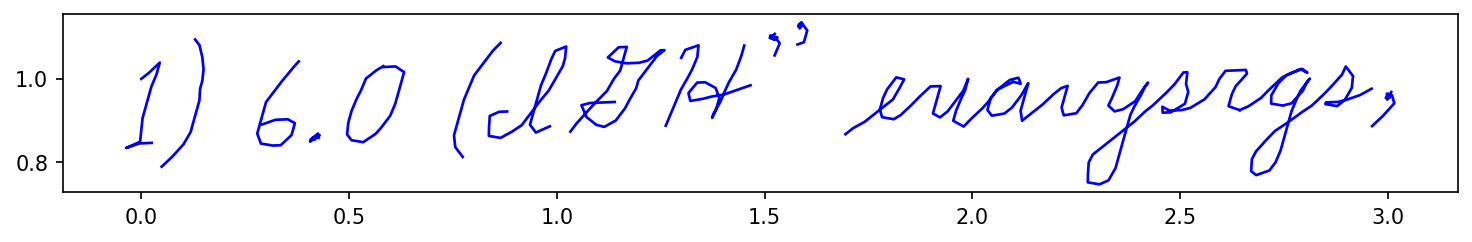

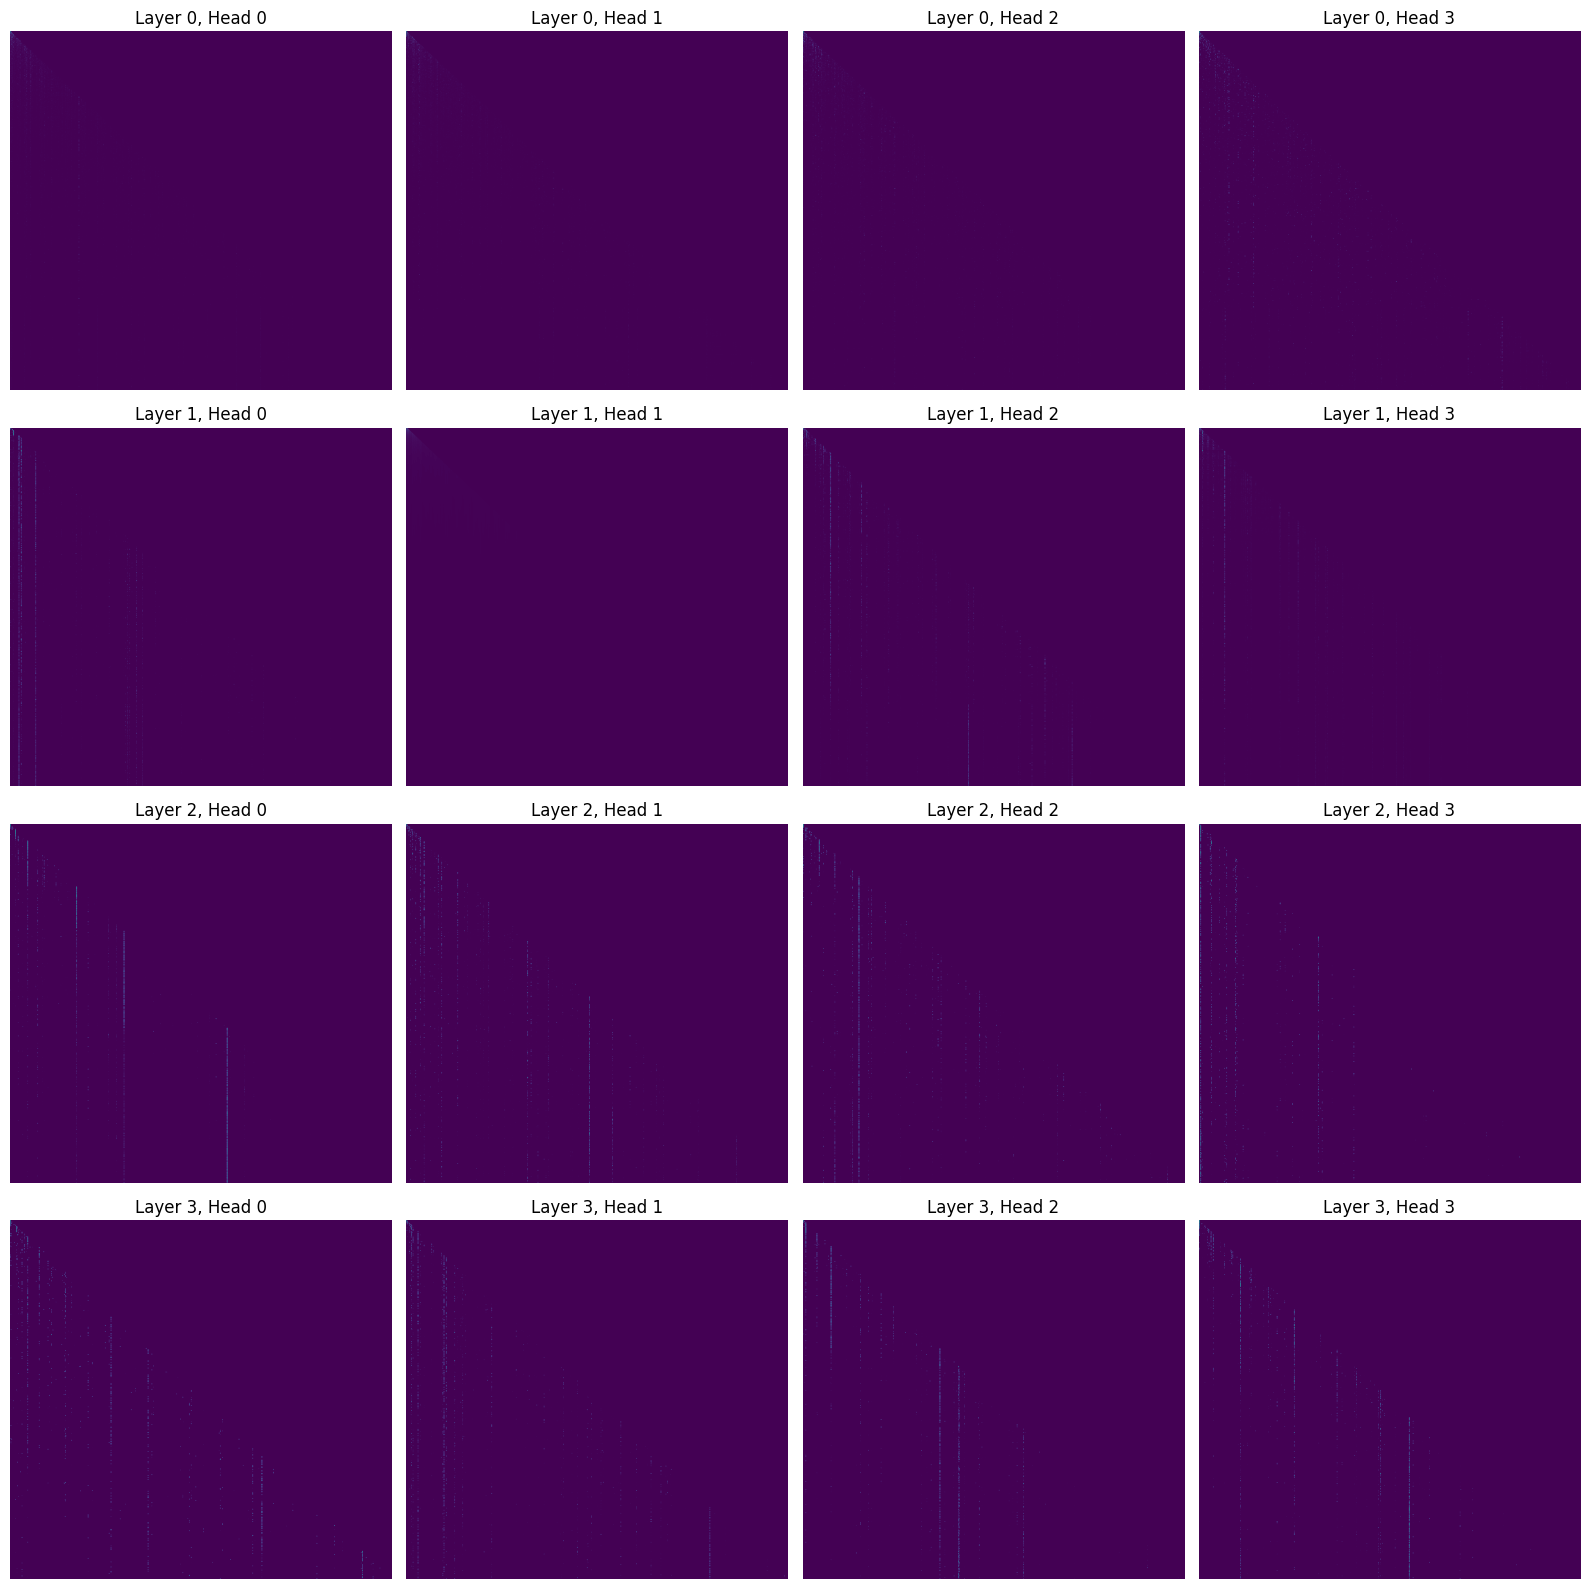

In [31]:
# Add batch dimension to your inputs
x, c, y = test_dataset[0]
x = x.unsqueeze(0) # Shape: [1, 1000]
c = c.unsqueeze(0) # Shape: [1, 50]
y = y.unsqueeze(0) # Shape: [1, 1000]


# - [ ] TODO: Add stroke plots to top-level figure
def visualize_attention(model, x, c, layer_range=None, head_range=None, attn_type='self'):
    with torch.no_grad():
        _, cache = model.run_with_cache(x, c, return_type="both")

    if layer_range is None:
        layer_range = range(model.cfg.n_layers)
    if head_range is None:
        head_range = range(model.cfg.n_heads)

    n_layers = len(layer_range)
    n_heads = len(head_range)

    fig, axes = plt.subplots(n_layers, n_heads, figsize=(4*n_heads, 4*n_layers), squeeze=False)

    for i, layer in enumerate(layer_range):
        for j, head in enumerate(head_range):
            if attn_type == 'self':
                attn_patterns = cache[f'blocks.{layer}.attn.hook_pattern']
            elif attn_type == 'cross':
                attn_patterns = cache[f'blocks.{layer}.cross_attn.hook_pattern']
            else:
                raise ValueError("attn_type must be 'self' or 'cross'")

            attn = attn_patterns[0, head].cpu().numpy()
            im = axes[i, j].imshow(attn, cmap='viridis', aspect='auto')
            axes[i, j].set_title(f'Layer {layer}, Head {head}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

_ = plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(x)),"")
_ = visualize_attention(model, x, c, layer_range=range(4), head_range=range(4), attn_type='self')

# Induction Head Detector

In [42]:
import plotly.express as px
import transformer_lens.utils as utils

In [54]:
batch_size = 10
seq_len = 100
size = (batch_size, seq_len)
input_tensor = torch.randint(0, cfg.d_vocab, size)

random_tokens = input_tensor
repeated_tokens = einops.repeat(random_tokens, "batch seq_len -> batch (2 seq_len)")

# Create context tensor
context_seq_len = model.cfg.context_block_size
context_vocab_size = model.cfg.context_vocab_size
context_size = (batch_size, context_seq_len)
context_tokens = torch.zeros(context_size, dtype=torch.int)

# Call the model
repeated_logits = model(repeated_tokens, context_tokens)

# Compute per-token losses using the updated loss_fn
correct_log_probs = model.loss_fn(repeated_logits, repeated_tokens, per_token=True)

# Compute loss by position
loss_by_position = einops.reduce(correct_log_probs, "batch position -> position", "mean")

# Plot the loss by position
line(loss_by_position, xaxis="Position", yaxis="Loss", title="Loss by position on random repeated tokens")

In [56]:
# We make a tensor to store the induction score for each head. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
induction_score_store = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=model.cfg.device)
def induction_score_hook(
    pattern: Float[torch.Tensor, "batch head_index dest_pos source_pos"],
    hook: HookPoint,
):
    # We take the diagonal of attention paid from each destination position to source positions seq_len-1 tokens back
    # (This only has entries for tokens with index>=seq_len)
    induction_stripe = pattern.diagonal(dim1=-2, dim2=-1, offset=1-seq_len)
    # Get an average score per head
    induction_score = einops.reduce(induction_stripe, "batch head_index position -> head_index", "mean")
    # Store the result.
    induction_score_store[hook.layer(), :] = induction_score

# We make a boolean filter on activation names, that's true only on attention pattern names.
pattern_hook_names_filter = lambda name: name.endswith("pattern")

_=model.run_with_hooks(
    repeated_tokens,
    context_tokens,
    #return_type=None, # For efficiency, we don't need to calculate the logits
    fwd_hooks=[(
        pattern_hook_names_filter,
        induction_score_hook
    )]
)

imshow(induction_score_store, xaxis="Head", yaxis="Layer", title="Induction Score by Head")

In [69]:
if IN_GITHUB:
    torch.manual_seed(50)

induction_head_layer = 0
induction_head_index = 3
size = (1, 20)
input_tensor = torch.randint(0, cfg.d_vocab, size)

single_random_sequence = input_tensor
repeated_random_sequence = einops.repeat(single_random_sequence, "batch seq_len -> batch (2 seq_len)")
context_tokens = torch.zeros(len(repeated_random_sequence), dtype=torch.int).unsqueeze(0)
def visualize_pattern_hook(
    pattern: Float[torch.Tensor, "batch head_index dest_pos source_pos"],
    hook: HookPoint,
):
    display(
        cv.attention.attention_patterns(
            tokens=repeated_random_sequence,
            attention=pattern[0, induction_head_index, :, :][None, :, :] # Add a dummy axis, as CircuitsVis expects 3D patterns.
        )
    )

model.run_with_hooks(
    repeated_random_sequence,
    context_tokens,
    #return_type=None,
    fwd_hooks=[(
        utils.get_act_name("pattern", induction_head_layer),
        visualize_pattern_hook
    )]
)

tensor([[[-0.3078, -0.1324,  0.5083,  ...,  0.1532,  0.2611,  0.4823],
         [-0.1946, -0.1614,  0.5562,  ...,  0.3412, -0.0698,  0.7028],
         [-0.0624, -0.1803,  0.6667,  ...,  0.2544, -0.1963,  0.4814],
         ...,
         [-0.2476, -0.4717,  0.4175,  ...,  0.0803, -0.0232,  0.3424],
         [ 0.1219, -0.4373,  0.4398,  ...,  0.2771,  0.0804,  0.7269],
         [-0.3720, -0.5496,  0.6522,  ...,  0.2028,  0.1120,  0.5480]]])

# Activation Patching

In [20]:
def activation_patching(
    model: HookedTransformer,
    x_clean: torch.Tensor,      # Clean input tokens
    c_clean: torch.Tensor,      # Clean context tokens
    x_corrupted: torch.Tensor,  # Corrupted input tokens
    c_corrupted: torch.Tensor,  # Corrupted context tokens
    patching_nodes: List[str],  # List of activation names to patch
    patch_positions: Optional[torch.Tensor] = None,  # Positions to patch
):
    """
    Perform activation patching from the corrupted run to the clean run.

    Args:
        model: The model.
        x_clean: Clean input tokens [batch_size, seq_len].
        c_clean: Clean context tokens [batch_size, context_len].
        x_corrupted: Corrupted input tokens [batch_size, seq_len].
        c_corrupted: Corrupted context tokens [batch_size, context_len].
        patching_nodes: List of activation names to patch.
        patch_positions: Positions to patch (if None, patch all positions).

    Returns:
        logits_patched: Logits after activation patching.
    """
    # device = model.cfg.device
    # x_clean = x_clean.to(device)
    # c_clean = c_clean.to(device)
    # x_corrupted = x_corrupted.to(device)
    # c_corrupted = c_corrupted.to(device)

    # Run the corrupted input and cache the activations
    _, cache_corrupted = model.run_with_cache(x_corrupted, c_corrupted, return_type="both")

    # Define the hook function
    def patching_hook(act, hook):
        act_corrupted = cache_corrupted[hook.name]
        if patch_positions is not None:
            # Only patch at specified positions
            act[:, patch_positions, :] = act_corrupted[:, patch_positions, :]
        else:
            # Patch all positions
            act[:] = act_corrupted
        return act

    # Create the list of hooks
    hooks = []
    for node in patching_nodes:
        hooks.append((node, patching_hook))

    # Run the clean input with hooks to patch activations
    logits_patched = model.run_with_hooks(x_clean, c_clean, fwd_hooks=hooks, return_type="logits")
    return logits_patched

In [21]:
# Example index from the test dataset
index = 0
x_clean, c_clean, y_clean = test_dataset[index]
x_clean = x_clean.unsqueeze(0)
c_clean = c_clean.unsqueeze(0)



# Create a corrupted version by modifying some tokens
x_corrupted = x_clean.clone()
# Introduce corruption: replace some tokens (e.g., shift tokens by 1 modulo vocab_size)
x_corrupted = (x_corrupted + 1) % model.cfg.d_vocab

# Context remains the same or can be modified accordingly
c_corrupted = c_clean.clone()

In [22]:
# Nodes to patch (e.g., output of attention heads in layer 0)
patching_nodes = ['blocks.0.attn.hook_result']

# Perform activation patching
logits_patched = activation_patching(
    model,
    x_clean,
    c_clean,
    x_corrupted,
    c_corrupted,
    patching_nodes,
)

# Get predictions from patched logits
predictions_patched = logits_patched.argmax(dim=-1)

Clean Predictions: tensor([[169, 423, 373, 447, 226, 300, 300, 378, 300, 412, 110, 137, 149, 231,
         110, 373, 359, 110, 110, 412, 226, 373, 100, 446, 129, 119, 213, 119,
         119, 261, 226, 231, 149, 370, 370,  40, 169,  92, 327, 327, 226, 226,
         359, 110, 373, 153, 280, 341, 169, 110, 447, 261,  54, 423, 412, 373,
         226, 226,  76, 447,  54, 226,  54, 412, 261, 412, 216, 446, 279, 169,
         412, 226, 226, 300, 373, 373, 231,   0, 110, 226, 446, 415, 373, 446,
         261, 100, 261, 226, 149,  54, 261, 373, 299, 373, 279, 280, 231, 279,
         412, 446, 373, 279, 248, 361, 300, 279, 373, 279, 438, 294, 443,  61,
          54, 226,  54, 231, 373,  54, 373, 149, 373, 446, 373, 149, 149, 100,
         261,  40, 412,  46, 412,  76, 446, 149, 373, 216, 412, 327, 110, 373,
         373, 373, 446,   6, 261, 446, 373, 446, 373, 248, 261, 446, 261, 192,
          54,  54, 110, 446, 359, 446, 248, 110, 373, 327, 300, 110, 373, 261,
         261, 261, 149, 150, 232,

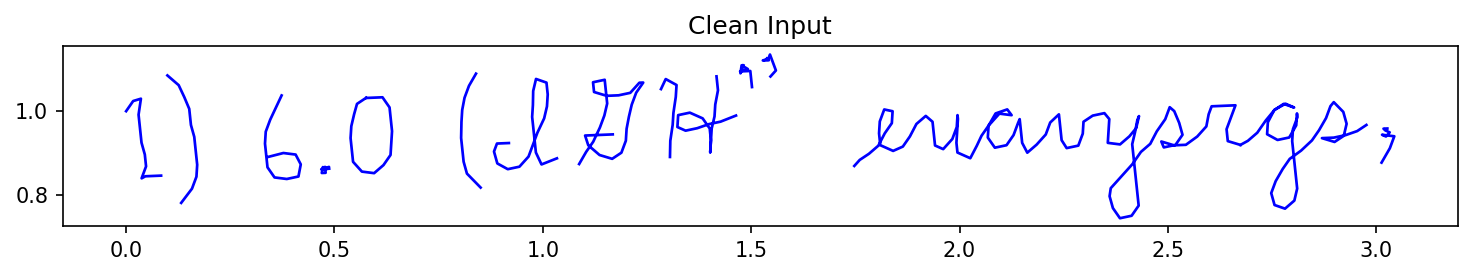

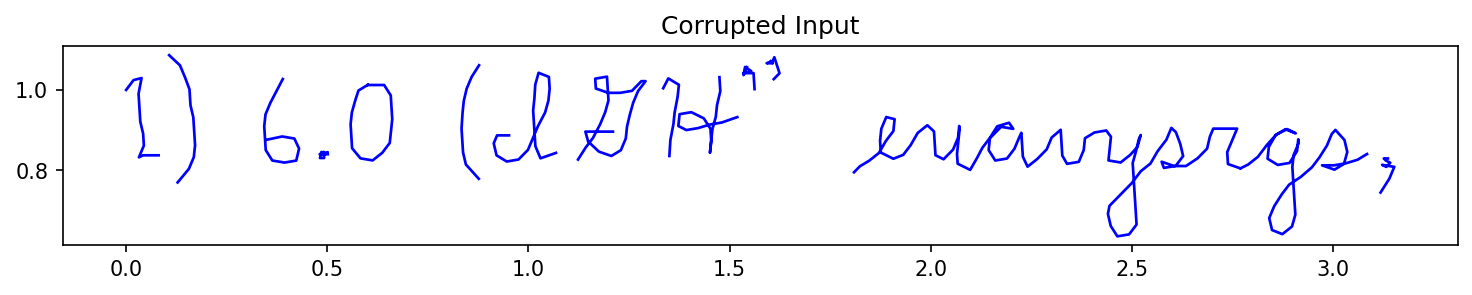

In [23]:
# Run the clean input without patches
logits_clean = model(x_clean, c_clean)
predictions_clean = logits_clean.argmax(dim=-1)

# Run the corrupted input without patches
logits_corrupted = model(x_corrupted, c_corrupted)
predictions_corrupted = logits_corrupted.argmax(dim=-1)

# Compare predictions
print("Clean Predictions:", predictions_clean)
print("Corrupted Predictions:", predictions_corrupted)
print("Patched Predictions:", predictions_patched)

# Visualize the strokes if applicable
_ = plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(x_clean)), "Clean Input")
_ = plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(x_corrupted)), "Corrupted Input")